# Modelling of a Geared DC Motor

**Balck-box modelling of 1D CNN, LSTM and Bidirictional LSTM**

- Input: PWM signal
- Output : Angular speed

In [29]:
#  Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import tensorflow as tf
import tensorflow
from numpy.random import seed
tf.random.set_seed(10)
# setting the seed
seed(10)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv1D, Flatten, Dropout,InputLayer

from tensorflow.keras.layers import RNN, Layer,LSTM, SimpleRNN
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow import float32, concat, convert_to_tensor, linalg

In [30]:
# data
exp_data = pd.read_csv("DC_Motor_experimental_data_training.csv")
exp_data

,0,40.5,0.1
0,0.020000,40.5,0.000000
1,0.040000,40.5,0.980267
2,0.060000,40.5,0.941830
3,0.080000,40.5,1.885167
4,0.100000,40.5,3.771782
...,...,...,...
24995,499.919983,255.0,300.932159
24996,499.940002,255.0,300.895599
24997,499.959992,255.0,300.860474
24998,499.979981,255.0,300.826721


In [31]:
exp_data.columns = ['time', 'voltage', 'speed']
exp_data

,time,voltage,speed
0,0.020000,40.5,0.000000
1,0.040000,40.5,0.980267
2,0.060000,40.5,0.941830
3,0.080000,40.5,1.885167
4,0.100000,40.5,3.771782
...,...,...,...
24995,499.919983,255.0,300.932159
24996,499.940002,255.0,300.895599
24997,499.959992,255.0,300.860474
24998,499.979981,255.0,300.826721


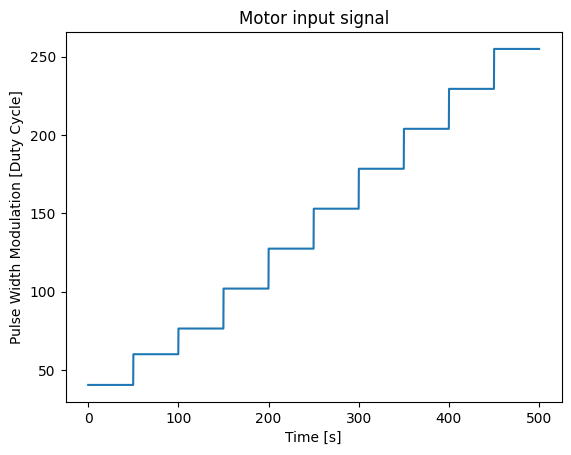

In [32]:
# Motor Input Signal
plt.plot(exp_data['time'][:-1],exp_data['voltage'][:-1])
plt.ylabel('Pulse Width Modulation [Duty Cycle]')
plt.xlabel('Time [s]')
plt.title('Motor input signal')
plt.show()
print('\n')

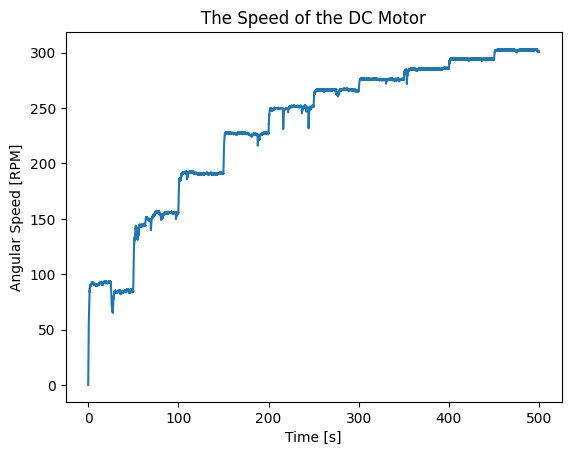

In [33]:
# Motor Output Plot
plt.plot(exp_data['time'][:-1],exp_data['speed'][:-1])
plt.ylabel('Angular Speed [RPM]')
plt.xlabel('Time [s]')
plt.title('The Speed of the DC Motor')
plt.show()
print('\n')

In [34]:
# Data for training
exp_data = pd.read_csv('DC_Motor_experimental_data_training.csv')
exp_data.columns = ['time', 'voltage', 'speed']
# range
l=25000
exp_data_tr=exp_data.iloc[0:l,:]

time=exp_data_tr['time']
t=np.array(time)

input_1=exp_data_tr['voltage']* (5/255)
xtr=np.array(input_1)
X_train=xtr.reshape(l,1)

output_1=exp_data_tr['speed']
ytr=np.array(output_1)
Y_train=ytr.reshape(l,1)

#Data for testing
new_data = pd.read_csv('DC_Motor_experimental_data_testing.csv')
new_data.columns = ['time', 'voltage', 'speed']

time_test=new_data['time']
t_test=np.array(time_test)

input_2=new_data['voltage']* (5/255)
xts=np.array(input_2)
X_test=xts.reshape(l,1)

output_2=new_data['speed']
yts=np.array(output_2)
Y_test=yts.reshape(l,1)

<h2> Data Transformation<h2>

In [35]:

def data_transform(x_data, y_data, num_steps):
    """ Changes data to the format for CNN and LSTM training for sliding window approach """
    # Prepare the list for the transformed data
    X, Y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x data
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y data
        seq_Y = y_data[end_ix]
        # Append the list with the sequence
        X.append(seq_X)
        Y.append(seq_Y)
    # Make final arrays
    x_trans_array = np.array(X)
    y_trans_array = np.array(Y)
    return x_trans_array, y_trans_array

In [36]:
# Training Data
num_steps = 1
x_new, y_new = data_transform(X_train, Y_train, num_steps=num_steps)
#print(x_new)
print ("The transformed shape of x and y are:", x_new.shape,"and", y_new.shape)


The transformed shape of x and y are: (24999, 1, 1) and (24999, 1)


In [37]:
# Test data
num_steps = 1
x_nnew, y_nnew = data_transform(X_test, Y_test, num_steps=num_steps)
print ("The transformed shape of x and y are:", x_nnew.shape,"and",y_nnew.shape)

The transformed shape of x and y are: (24999, 1, 1) and (24999, 1)


Epoch 19/20
782/782 - 8s - loss: 20.2446 - val_loss: 34.4284
Epoch 20/20
782/782 - 7s - loss: 20.2037 - val_loss: 30.0333

Computation time: 148.67806911468506 seconds

In [38]:
# Define R-squared metric
def r2_keras(y_true, y_pred):
    residual = K.sum(K.square(y_true - y_pred))
    total = K.sum(K.square(y_true - K.mean(y_true)))
    r2 = 1 - residual / (total + K.epsilon())
    return r2

<h2>1D CNN Model<h2>

In [36]:
model1=Sequential()
model1.add(Conv1D(filters=128,kernel_size=1, activation='tanh', input_shape=(num_steps,1)))
model1.add(Conv1D(filters=64,kernel_size=1, activation='tanh'))
model1.add(Flatten())
model1.add(Dense(5, activation='relu'))
model1.add(Dense(1, activation='linear'))

# Model Compile and Fit
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.005)
model1.compile(optimizer=opt, loss='mse', metrics=[r2_keras])
model1.summary()

from time import time
# Start timer
t0 = time()
hist1=model1.fit(x_new, y_new, epochs=20,verbose=2,validation_data=(x_nnew,y_nnew))
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 1, 128)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 1, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 5)              │           325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,843 (34.54 KB)

 Trainable params: 8,843 (34.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
782/782 - 2s - 3ms/step - loss: 11083.0342 - r2_keras: -1.7308e+00 - val_loss: 34.3565 - val_r2_keras: -4.7321e+04
Epoch 2/20
782/782 - 1s - 1ms/step - loss: 24.5464 - r2_keras: 0.9946 - val_loss: 38.1662 - val_r2_keras: -1.5896e+05
Epoch 3/20
782/782 - 1s - 1ms/step - loss: 23.4835 - r2_keras: 0.9948 - val_loss: 48.5234 - val_r2_keras: -1.8097e+05
Epoch 4/20
782/782 - 1s - 1ms/step - loss: 22.7765 - r2_keras: 0.9950 - val_loss: 44.5320 - val_r2_keras: -1.7880e+05
Epoch 5/20
782/782 - 1s - 1ms/step - loss: 22.2641 - r2_keras: 0.9951 - val_loss: 38.3234 - val_r2_keras: -1.0404e+05
Epoch 6/20
782/782 - 1s - 1ms/step - loss: 21.9847 - r2_keras: 0.9952 - val_loss: 34.6071 - val_r2_keras: -5.3809e+04
Epoch 7/20
782/782 - 1s - 1ms/step - loss: 21.5826 - r2_keras: 0.9953 - val_loss: 31.2706 - val_r2_keras: -2.1077e+04
Epoch 8/20
782/782 - 1s - 1ms/step - loss: 21.1559 - r2_keras: 0.9954 - val_loss: 29.1334 - val_r2_keras: -5.8237e+02
Epoch 9/20
782/782 - 1s - 2ms/step - loss: 20.74

<h5>Save CNN Model<h5>

In [30]:
# save model and architecture to single file
#model1.save("DC_motor_model_CNN.h5")
#print("Model has been saved to disk")
from tensorflow.keras.models import load_model
# load model
model1 = load_model('DC_motor_model_CNN.h5')

dict_keys(['loss', 'r2_keras', 'val_loss', 'val_r2_keras'])


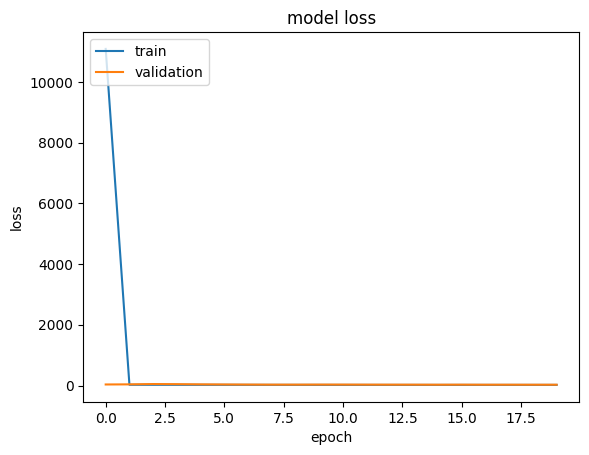

In [37]:
#Plotting of Loss
print(hist1.history.keys())
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [38]:
# Prediiction with test data
prediction1=model1.predict(x_nnew) ######### prediction with test data
print(prediction1.shape)
prediction1

782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
(24999, 1)


array([[ 86.35527],
       [ 86.35527],
       [ 86.35527],
       ...,
       [302.62622],
       [302.62622],
       [302.62622]], dtype=float32)

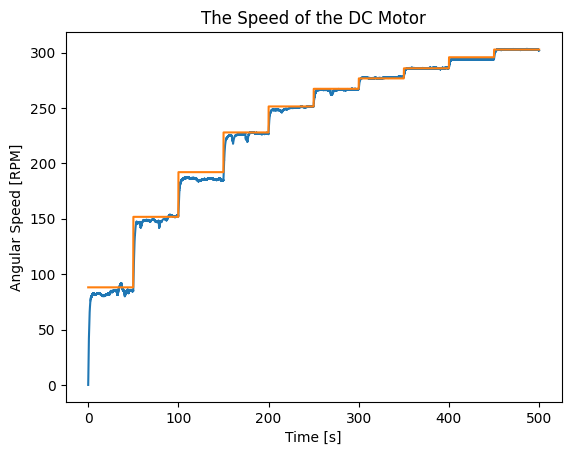

In [20]:
# Plottinf the Model Prediction
plt.plot(t_test[num_steps:],y_nnew)
plt.plot(t_test[num_steps:],prediction1)
plt.ylabel('Angular Speed [RPM]')
plt.xlabel('Time [s]')
plt.title('The Speed of the DC Motor')
plt.show()
print('\n')

<h2>LSTM Model<h2>

In [41]:
model2 = Sequential()
model2.add(LSTM(100, activation='tanh', input_shape=(num_steps, 1),return_sequences=False))
model2.add(Dense(units=50, activation='relu'))
model2.add(Dense(units=1, activation='linear'))
adam = tensorflow.keras.optimizers.Adam(learning_rate=0.0005)
model2.compile(optimizer=adam, loss='mse',metrics=[r2_keras])
from time import time

t0 = time()
hist2=model2.fit(x_new, y_new, epochs=20,verbose=2,validation_data=(x_nnew,y_nnew))

print('\nComputation time: {} seconds'.format(time()-t0))


Epoch 1/20
782/782 - 3s - 4ms/step - loss: 23574.1875 - r2_keras: -4.8800e+00 - val_loss: 288.2151 - val_r2_keras: -3.5232e+06
Epoch 2/20
782/782 - 1s - 2ms/step - loss: 262.6712 - r2_keras: 0.9395 - val_loss: 264.5916 - val_r2_keras: -2.6242e+06
Epoch 3/20
782/782 - 1s - 2ms/step - loss: 235.8225 - r2_keras: 0.9457 - val_loss: 230.1885 - val_r2_keras: -2.1796e+06
Epoch 4/20
782/782 - 1s - 2ms/step - loss: 199.1498 - r2_keras: 0.9541 - val_loss: 186.4430 - val_r2_keras: -1.6129e+06
Epoch 5/20
782/782 - 1s - 2ms/step - loss: 154.9512 - r2_keras: 0.9643 - val_loss: 137.5977 - val_r2_keras: -1.0016e+06
Epoch 6/20
782/782 - 1s - 2ms/step - loss: 109.3030 - r2_keras: 0.9749 - val_loss: 91.9214 - val_r2_keras: -4.7117e+05
Epoch 7/20
782/782 - 1s - 2ms/step - loss: 70.5853 - r2_keras: 0.9839 - val_loss: 58.1840 - val_r2_keras: -1.3181e+05
Epoch 8/20
782/782 - 1s - 2ms/step - loss: 45.2587 - r2_keras: 0.9898 - val_loss: 40.0668 - val_r2_keras: -7.4639e+03
Epoch 9/20
782/782 - 1s - 2ms/step - l

dict_keys(['loss', 'r2_keras', 'val_loss', 'val_r2_keras'])


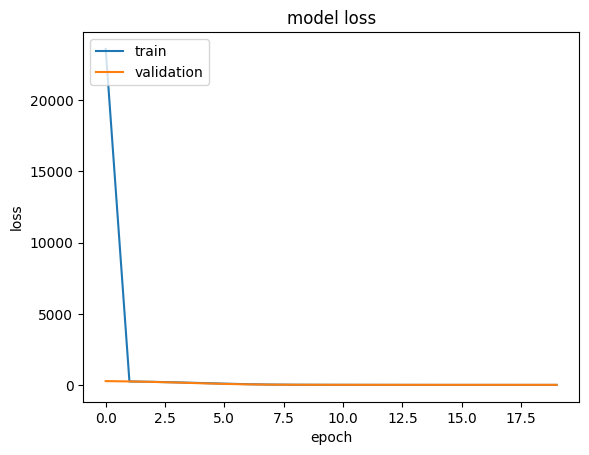

In [42]:
#Plotting of Loss
print(hist2.history.keys())
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [43]:
# Prediiction with test data
prediction2=model2.predict(x_nnew) 
print(prediction2.shape)
prediction2

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step
(24999, 1)


array([[ 86.100624],
       [ 86.100624],
       [ 86.100624],
       ...,
       [301.70758 ],
       [301.70758 ],
       [301.70758 ]], dtype=float32)

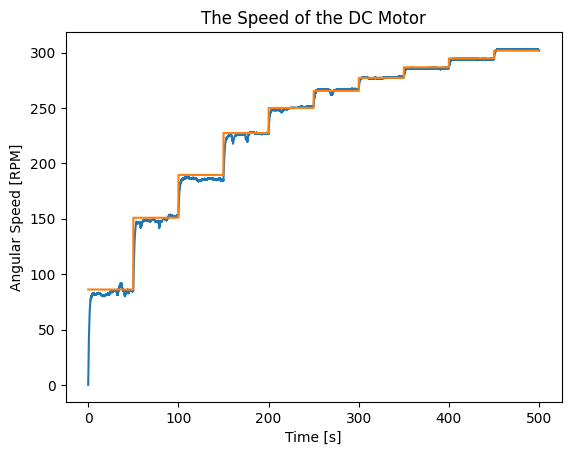

In [44]:
# Plotting the Model Prediction
plt.plot(t_test[num_steps:],y_nnew)
plt.plot(t_test[num_steps:],prediction2)
plt.ylabel('Angular Speed [RPM]')
plt.xlabel('Time [s]')
plt.title('The Speed of the DC Motor')
plt.show()
print('\n')

# Bidirictional LSTM

Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 21202.7461 - val_loss: 295.3608
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 371.2774 - val_loss: 0.7622
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 175.5104 - val_loss: 11.1741
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 82.1137 - val_loss: 67.0759
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 47.2950 - val_loss: 67.7202
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 32.0798 - val_loss: 41.3753
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 25.7911 - val_loss: 1.0277
Epoch 8/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 22.1001 - val_loss: 10.1656
Epoch 9/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 21.3078 - val_loss: 15.8529
Epoch 10/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 21.2398 - val_loss: 15.6674
Epoch 11/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 21.2036 - val_loss: 14.1004
Epoch 12/20
704/704 ━━━━━━

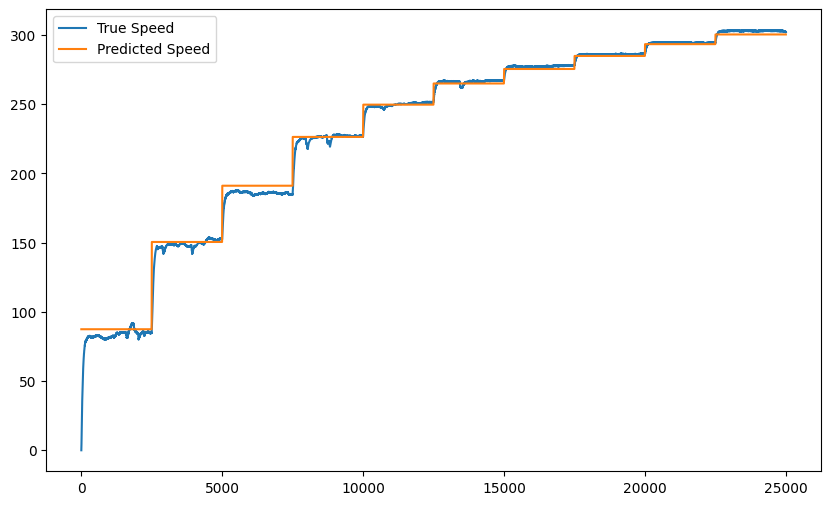

In [50]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, InputLayer

model = Sequential([
    InputLayer(input_shape=(num_steps, 1)),  # Input layer
    
    # First Bidirectional LSTM layer
    Bidirectional(LSTM(50, activation='relu', return_sequences=True)),
    
    # Second Bidirectional LSTM layer
    Bidirectional(LSTM(50, activation='relu')),
    
    # First Dense layer with 64 units
    Dense(64, activation='relu'),
    
    # Second Dense layer with 32 units
    Dense(32, activation='relu'),
    
    # Output layer
    Dense(1)  # Linear output layer
])

# Compiling the model
model.compile(optimizer='adam', loss='mse')

# Training the model
history = model.fit(x_new, y_new, epochs=20, validation_split=0.1)

# Transforming the test data with the sliding window approach
num_steps = 1
x_nnew, y_nnew = data_transform(X_test, Y_test, num_steps=num_steps)

# Making predictions on the test data
predictions = model.predict(x_nnew)

# Plotting the results
plt.figure(figsize=(10,6))
plt.plot(y_nnew, label='True Speed')
plt.plot(predictions, label='Predicted Speed')
plt.legend()
plt.show()


In [53]:


# Prediiction with test data
prediction4=model.predict(x_nnew) ######### prediction with test data
print(prediction4.shape)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
(24999, 1)


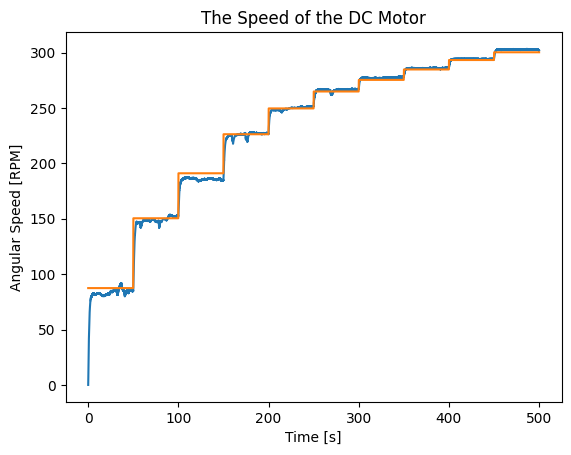

In [54]:
# Plotting the Model Prediction
plt.plot(t_test[num_steps:],y_nnew)
plt.plot(t_test[num_steps:],prediction4)
plt.ylabel('Angular Speed [RPM]')
plt.xlabel('Time [s]')
plt.title('The Speed of the DC Motor')
plt.show()
print('\n')